In [2]:
import numpy as np
np.random.seed(42)
import sys
import cProfile
import h5py
sys.path.insert(0, '../..')
%reload_ext memory_profiler
%reload_ext autoreload
%autoreload 1
import allel; print(allel.__version__)
%aimport allel.stats.selection

0.21.0.dev0


In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

In [4]:
callset = h5py.File('/data/coluzzi/ag1000g/data/phase1/release/AR3/haplotypes/main/hdf5/ag1000g.phase1.ar3.haplotypes.3R.h5',
                    mode='r')
callset

<HDF5 file "ag1000g.phase1.ar3.haplotypes.3R.h5" (mode r)>

In [5]:
n_variants = 500000
n_samples = 100

h = allel.GenotypeArray(callset['3R']['calldata/genotype'][:n_variants, :n_samples]).to_haplotypes()
h

,0,1,2,3,4,...,195,196,197,198,199
0,0,0,0,0,0,...,0,0,0,0,0
1,0,0,0,0,0,...,0,0,0,0,0
2,0,0,0,0,0,...,0,0,0,0,0
3,0,0,0,0,0,...,0,0,0,0,0
4,0,0,0,0,0,...,0,0,0,0,0


In [6]:
pos = callset['3R']['variants/POS'][:n_variants]
pos

array([   1252,    1262,    1271, ..., 1927216, 1927221, 1927229], dtype=int32)

In [7]:
ac = h.count_alleles(max_allele=1)
is_seg = ac.is_segregating() & (ac.min(axis=1) > 1)
h_seg = h.compress(is_seg, axis=0)
pos_seg = pos.compress(is_seg)
ac_seg = ac.compress(is_seg, axis=0)
np.count_nonzero(is_seg)

106315

In [8]:
%%time
score_0min = allel.stats.ihs(h_seg, pos_seg, min_ehh=0, include_edges=True, use_threads=False)

CPU times: user 18.4 s, sys: 0 ns, total: 18.4 s
Wall time: 18.4 s


In [9]:
%%time
score = allel.stats.ihs(h_seg, pos_seg, min_ehh=0.05, include_edges=True, use_threads=False)

CPU times: user 13.4 s, sys: 0 ns, total: 13.4 s
Wall time: 13.4 s


In [10]:
%%time
score_threaded = allel.stats.ihs(h_seg, pos_seg, min_ehh=0.05, include_edges=True, use_threads=True)

CPU times: user 14.3 s, sys: 0 ns, total: 14.3 s
Wall time: 7.22 s


In [11]:
score_threaded

array([        nan,  4.0518796 ,  0.6314155 , ..., -0.36802878,
        1.13779695,         nan])

In [12]:
score

array([        nan,  4.0518796 ,  0.6314155 , ..., -0.36802878,
        1.13779695,         nan])

In [13]:
np.count_nonzero(np.isnan(score)), np.count_nonzero(~np.isnan(score))

(1452, 104863)

In [14]:
np.count_nonzero(np.isinf(score)), np.count_nonzero(~np.isinf(score))

(0, 106315)

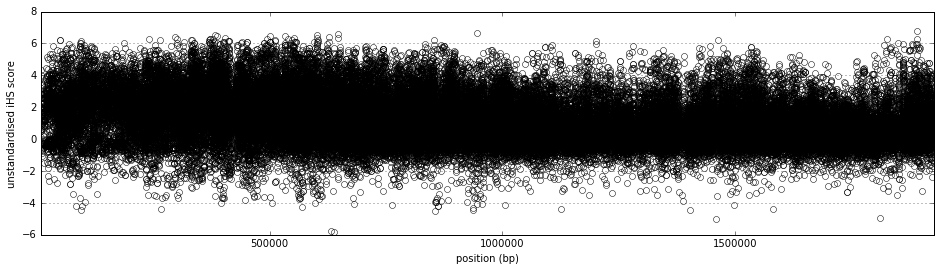

In [15]:
plt.figure(figsize=(16, 4))
plt.plot(pos_seg, score, linestyle=' ', marker='o', mfc='none')
plt.grid(axis='y')
plt.xlabel('position (bp)')
plt.ylabel('unstandardised iHS score')
plt.autoscale(axis='x', tight=True);

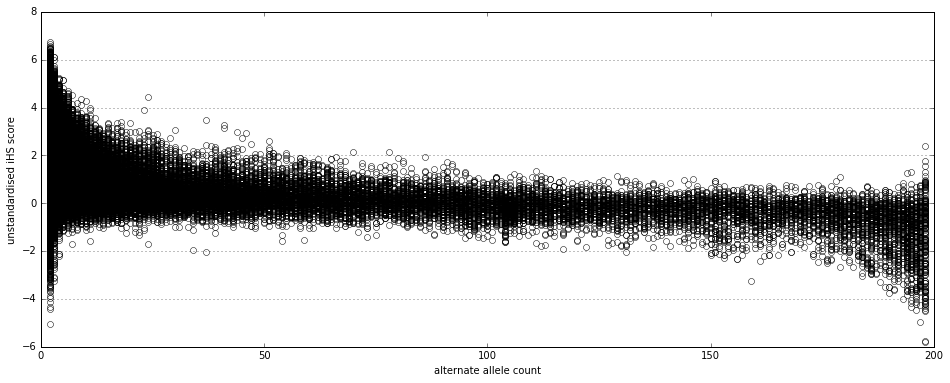

In [16]:
plt.figure(figsize=(16, 6))
plt.plot(ac_seg[:, 1], score, linestyle=' ', marker='o', mfc='none')
plt.xlabel('alternate allele count')
plt.ylabel('unstandardised iHS score')
plt.grid(axis='y');

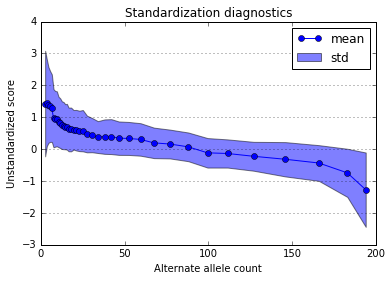

In [17]:
score_standardized, ac_bins = allel.stats.standardize_by_allele_count(score, ac_seg[:, 1])

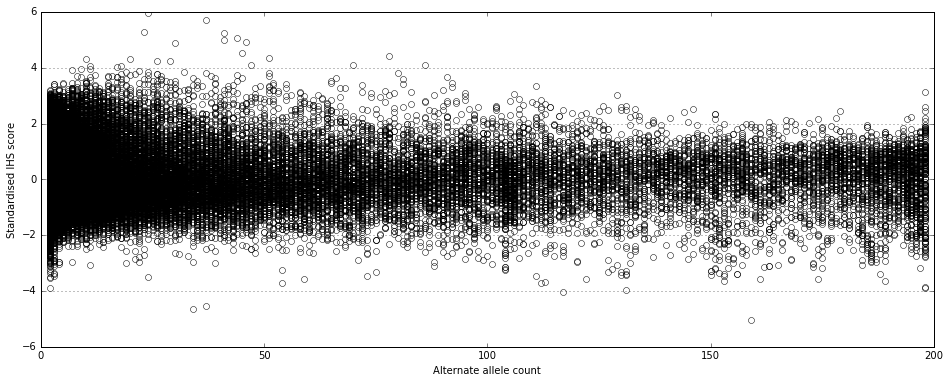

In [18]:
plt.figure(figsize=(16, 6))
plt.plot(ac_seg[:, 1], score_standardized, linestyle=' ', marker='o', mfc='none')
plt.xlabel('Alternate allele count')
plt.ylabel('Standardised IHS score')
plt.grid(axis='y');

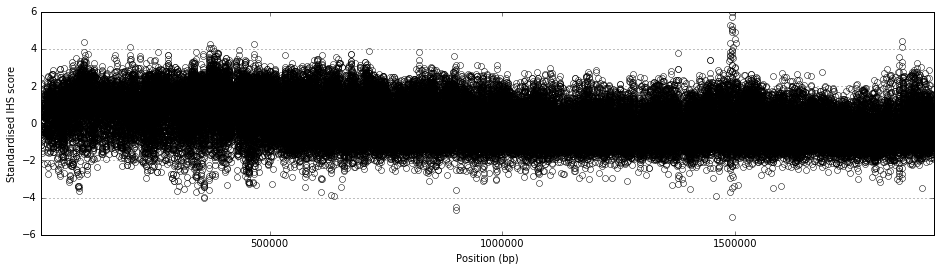

In [19]:
plt.figure(figsize=(16, 4))
plt.plot(pos_seg, score_standardized, linestyle=' ', marker='o', mfc='none')
plt.grid(axis='y')
plt.xlabel('Position (bp)')
plt.ylabel('Standardised IHS score')
plt.autoscale(axis='x', tight=True);

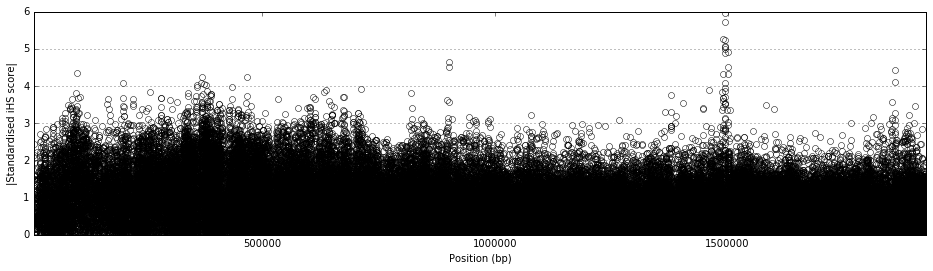

In [20]:
plt.figure(figsize=(16, 4))
plt.plot(pos_seg, np.abs(score_standardized), linestyle=' ', marker='o', mfc='none')
plt.grid(axis='y')
plt.xlabel('Position (bp)')
plt.ylabel('|Standardised iHS score|')
plt.autoscale(axis='x', tight=True);

In [21]:
h_seg.shape

(106315, 200)

In [22]:
cProfile.run('allel.stats.ihs(h_seg[:50000], pos_seg[:50000], min_ehh=0.05, include_edges=True, use_threads=False)', sort='time')

         118 function calls in 6.795 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        2    6.793    3.397    6.793    3.397 stats.pyx:719(ihh01_scan_int8)
        1    0.002    0.002    6.795    6.795 selection.py:378(ihs)
        1    0.000    0.000    6.795    6.795 {built-in method builtins.exec}
        7    0.000    0.000    0.000    0.000 {built-in method numpy.core.multiarray.array}
        2    0.000    0.000    0.000    0.000 ndarray.py:1810(__getitem__)
       18    0.000    0.000    0.000    0.000 stringsource:341(__cinit__)
        1    0.000    0.000    6.795    6.795 <string>:1(<module>)
        4    0.000    0.000    0.000    0.000 stringsource:985(memoryview_fromslice)
        6    0.000    0.000    0.000    0.000 numeric.py:414(asarray)
        2    0.000    0.000    6.793    3.397 {allel.opt.stats.ihh01_scan_int8}
        1    0.000    0.000    0.000    0.000 ndarray.py:1776(__new__)
       14    0.

## Gap handling

In [23]:
loc_variants = slice(4000000, 9000000, 1)
n_samples = 50

h = allel.GenotypeArray(callset['3R']['calldata/genotype'][loc_variants, :n_samples]).to_haplotypes()
h

,0,1,2,3,4,...,95,96,97,98,99
0,0,0,0,0,0,...,0,0,0,0,0
1,0,0,0,0,0,...,0,0,0,0,0
2,0,0,0,0,0,...,0,0,0,0,0
3,0,0,0,0,0,...,0,0,0,0,0
4,0,0,0,0,0,...,0,0,0,0,0


In [24]:
pos = callset['3R']['variants/POS'][loc_variants]
pos

array([16532852, 16532853, 16532854, ..., 42555205, 42555210, 42555213], dtype=int32)

In [25]:
ac = h.count_alleles(max_allele=1)
is_seg = ac.is_segregating() & (ac.min(axis=1) > 10)
h_seg = h.compress(is_seg, axis=0)
pos_seg = pos.compress(is_seg)
ac_seg = ac.compress(is_seg, axis=0)
np.count_nonzero(is_seg)

211040

In [41]:
def plot_score_gap(score, pos, ylim=(-12, 12)):

    fig = plt.figure(figsize=(16, 4))

    ax = fig.add_subplot(111)
    ax.plot(pos, score, linestyle=' ', marker='o', mfc='none', markersize=2)
    ax.grid(axis='y')
    ax.set_xlabel('position (bp)')
    ax.set_ylabel('score')
    ax.set_ylim(*ylim)

    ax = ax.twinx()
    x = (pos[:-1] + pos[1:]) / 2
    y = np.diff(pos)
    ax.plot(x, y)
    ax.set_ylabel('gap size (bp)')
    ax.autoscale(axis='x', tight=True);

In [27]:
accessibility = h5py.File('/data/coluzzi/ag1000g/data/phase1/release/AR3/accessibility/accessibility.h5', mode='r')
is_accessible = accessibility['3R']['is_accessible'][:]
is_accessible

array([False, False, False, ..., False, False, False], dtype=bool)

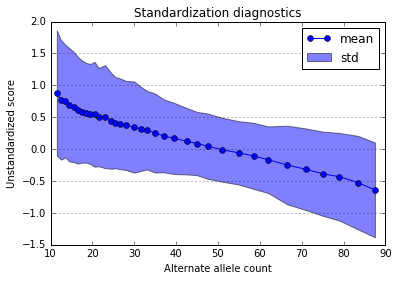

In [28]:
score_unadjusted = allel.stats.ihs(h_seg, pos_seg, min_ehh=0.05, max_gap=-1, clip_gap=-1)
score_unadjusted, _ = allel.stats.standardize_by_allele_count(score_unadjusted, ac_seg[:, 1])

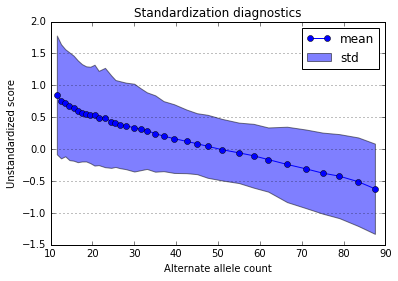

In [29]:
score_gap_adjusted = allel.stats.ihs(h_seg, pos_seg, min_ehh=0.05, max_gap=200000, clip_gap=1000)
score_gap_adjusted, _ = allel.stats.standardize_by_allele_count(score_gap_adjusted, ac_seg[:, 1])

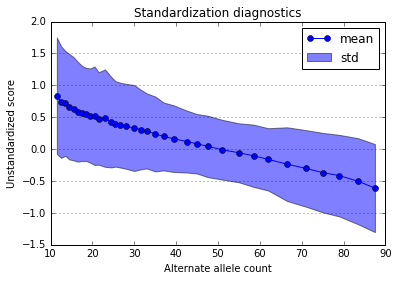

In [30]:
score_access_adjusted = allel.stats.ihs(h_seg, pos_seg, min_ehh=0.05, max_gap=-1, clip_gap=-1, 
                                        is_accessible=is_accessible)
score_access_adjusted, _ = allel.stats.standardize_by_allele_count(score_access_adjusted, ac_seg[:, 1])

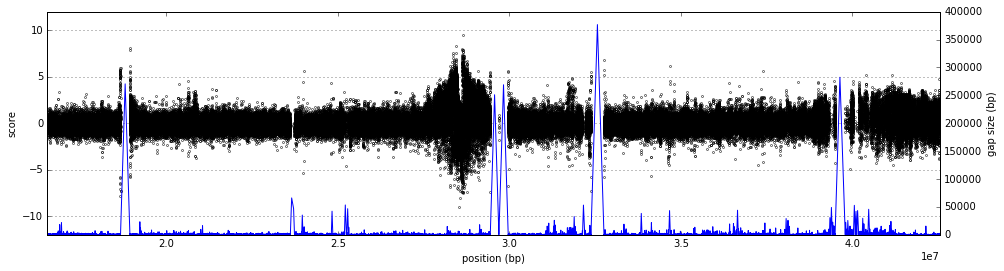

In [42]:
plot_score_gap(score_unadjusted, pos_seg)

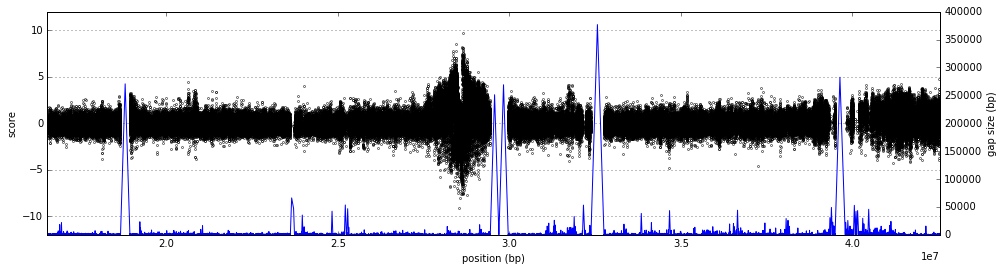

In [43]:
plot_score_gap(score_gap_adjusted, pos_seg)

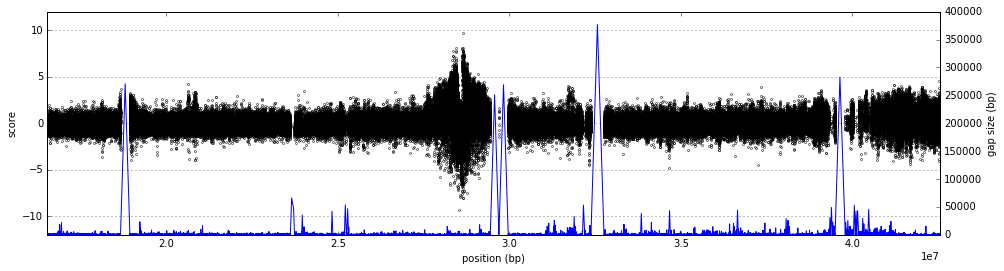

In [44]:
plot_score_gap(score_access_adjusted, pos_seg)

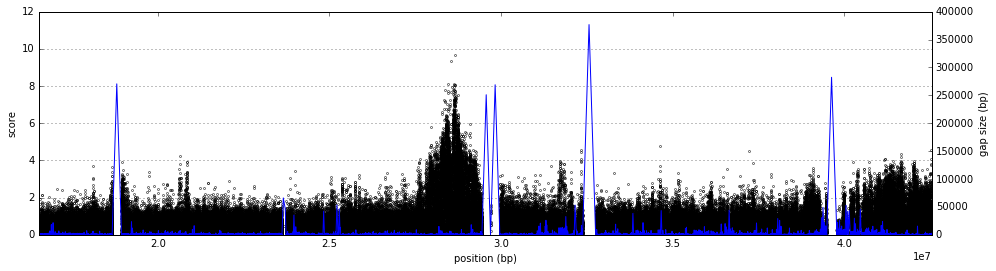

In [45]:
plot_score_gap(np.abs(score_access_adjusted), pos_seg, ylim=(0, 12))

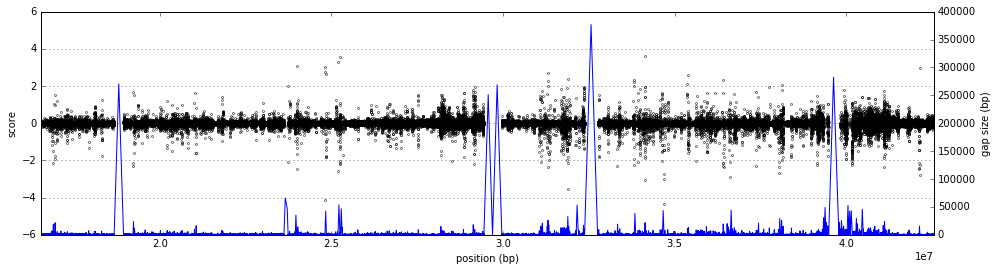

In [46]:
plot_score_gap(score_gap_adjusted - score_unadjusted, pos_seg, ylim=(-6, 6))

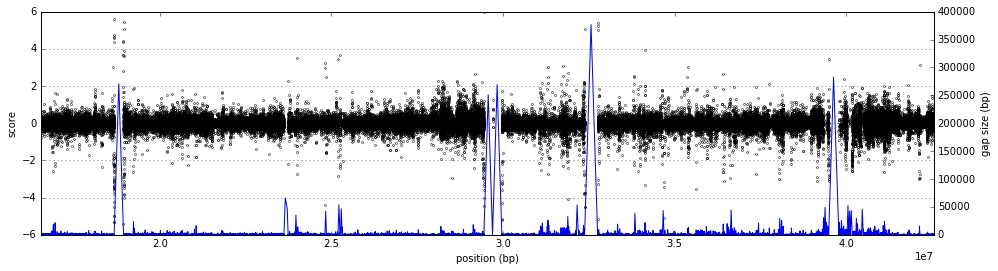

In [47]:
plot_score_gap(score_access_adjusted - score_unadjusted, pos_seg, ylim=(-6, 6))

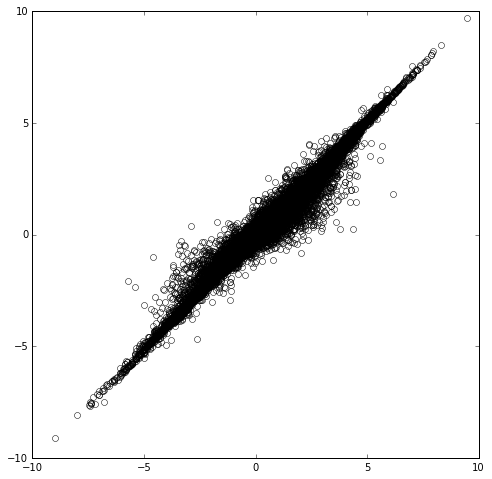

In [48]:
plt.figure(figsize=(8, 8))
plt.plot(score_unadjusted, score_gap_adjusted, marker='o', mfc='none', linestyle=' ');

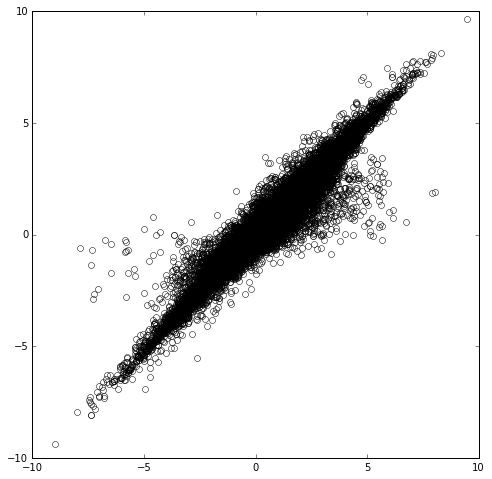

In [49]:
plt.figure(figsize=(8, 8))
plt.plot(score_unadjusted, score_access_adjusted, marker='o', mfc='none', linestyle=' ');

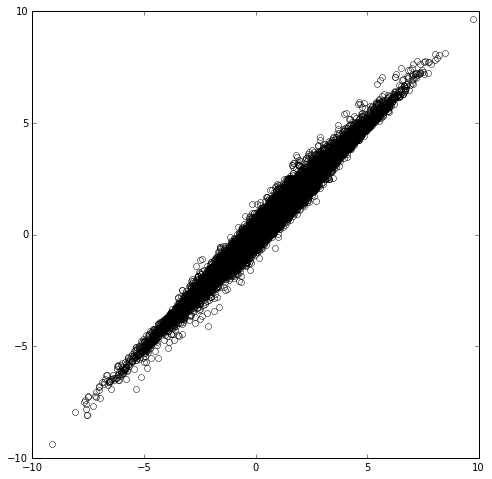

In [50]:
plt.figure(figsize=(8, 8))
plt.plot(score_gap_adjusted, score_access_adjusted, marker='o', mfc='none', linestyle=' ');